<a href="https://colab.research.google.com/github/EdisonMaxwell/udacity_mlnd_capstone/blob/master/3_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying urban sounds using deep learning models.
## Model Training and Evaluation
### Load preprocessed data

The data is loaded from a .npz file that contains prepocessed data that was previously created. After loading the data will be split into training, validation and testing sets. 

In [2]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Retrieve contents of the data file.
import numpy as np

file_path = '/content/drive/My Drive/mlnd_data/dataset.npz'
contents = np.load(file_path)

X = contents['features']
y = contents['labels']

In [0]:
#Data is split into training and testing sets.
from sklearn.model_selection import train_test_split 
random_state = 538

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, shuffle=True ,random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=random_state)

### Convolutional Neural Network model architecture
CNNs are some of the best tools for image classification do to their ability to quantify spatial relationships. 
Our architecture will be a relatively small `Sequential`model consisting of 3 `Conv2D`convolution layers each followed by a `Pool2D` pooling layer. Finally, the output is from a `Dense` layer connected to the Convolutional.
    
The convolutional layer perform the actual feature selection. It slides a small window(aka kernek aka filter) with weights on it over the pixels of the image. It starts at the top and performs summation matrix operations and saves the result as part of an activation map. This process is called convolution. The filter parameter specifies the number of filters that will be applied to a layer in the CNN. Each layer of a CNN can have many filters. Each filter learns something differnt about the problem statment and crosses the activation threshold for different inputs.

The pooling layers reduce dimensionality wihout much loss in data. This increases robustness of the model and lowers its compute and storage requirements. Two type of pooling layers will be used in the model. Firstly, `Pool2D` will be used between Convolutional layers to reduce dimensionality while preserving spatial information. 

After features are extracted, they are fed into a `GlobalAveragePooling2D` layer to flatten the features into a vector while preserving more information than simply flattening it with the `Flatten` layer.

The output layer will have 10 nodes which matches the number of target classes. The `Softmax` activation function will used on the output layer giving us a vector of probabilities.

In [6]:
%tensorflow_version 2.x

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization


width = 40
height = 175
channels = 1

X_train = X_train.reshape(X_train.shape[0],width,height,channels)
X_test = X_test.reshape(X_test.shape[0],width,height,channels)
X_val = X_val.reshape(X_val.shape[0],width,height,channels)

label_count = y.shape[1]

model = Sequential([
    Conv2D(filters=16,kernel_size=2,input_shape=(width,height,channels),activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.1),
        
    Conv2D(filters=32,kernel_size=2,activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.1),
    
    Conv2D(filters=64,kernel_size=2,activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.1),
    
    Conv2D(filters=128,kernel_size=2,activation='relu'),
    GlobalAveragePooling2D(),
    
    Dense(units=128,activation='tanh'),
    BatchNormalization(),
    Dense(units=label_count,activation='softmax')  
])

model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

TensorFlow 2.x selected.


### Model Compilation

In [7]:
# Model architecture
model.summary()

#pretraining_accuracy
score = model.evaluate(X_test,y_test,verbose=1)
accuracy = 100*score[1]

print('Pretraining accuracy:%.4f%%' % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 174, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 87, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 87, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 86, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 43, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 43, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 42, 64)         8

### Training

The training of the model begins. CNNs are best trained on the GPU because of their high parallelization capability. One can train lower epoch numbers on the CPU.

In [8]:
!pip install keras-tqdm

In [9]:
%%timeit

from keras_tqdm import TQDMNotebookCallback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, History,TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold

#learning rate reduction
MAX_PATIENCE = 2

best_filepath ='/content/drive/My Drive/mlnd_data/best_model.hdf5'

#callbacks
callback = [ReduceLROnPlateau(patience = MAX_PATIENCE, verbose = 0),
            ModelCheckpoint(filepath=best_filepath,monitor='val_loss',verbose=0,save_best_only=True),
            TQDMNotebookCallback(leave_inner=None),
            TensorBoard(log_dir='training_logs',histogram_freq=0,write_graph=True,write_images=True)]

#compile
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

#train
model.fit(x=X_train,y=y_train,epochs=50,batch_size=64,verbose=0, validation_data = (X_val,y_val), shuffle=True, callbacks=callback)

Using TensorFlow backend.



1 loop, best of 3: 47.8 s per loop


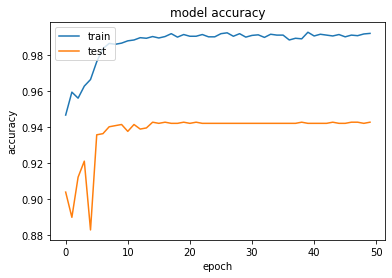

In [10]:
import matplotlib.pyplot as plt

history =  model.history.history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

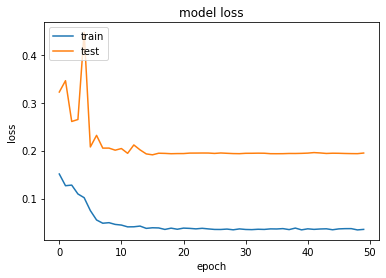

In [11]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
score = model.evaluate(X_test,y_test,verbose=1)
accuracy = 100*score[1]

874/874 [==============================] - 0s 96us/sample - loss: 0.1795 - accuracy: 0.9508
